In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

# !ls

In [1]:
import os

home_dir = '/content/gdrive/My Drive/AChina' 
home_dir = '/hy-tmp'
os.chdir(home_dir)
!pwd

!pip install tqdm 

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

/hy-tmp
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")

In [3]:
# !pip install torch torchvision
# !pip install pytorch_lightning
# !pip install pytorch_forecasting

# !pip install torch -f https://download.pytorch.org/whl/torch_stable.html
# !pip install pytorch-forecasting

!pip install scipy
!pip install torch pytorch-lightning pytorch_forecasting

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [4]:
data = pd.read_csv('corn_china_pandas_onebands.csv')  # encoding= 'unicode_escape')

data[0:15]

,Unnamed: 0,years,yield,sownareas,yieldvals,county,MODIS,time_idx,band_0_0,band_0_1,...,band_8_502,band_8_503,band_8_504,band_8_505,band_8_506,band_8_507,band_8_508,band_8_509,band_8_510,band_8_511
0,0,2003,0.61295,75.21,46.1,0,MOD_0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2003,0.61295,75.21,46.1,0,MOD_1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2003,0.61295,75.21,46.1,0,MOD_2,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2003,0.61295,75.21,46.1,0,MOD_3,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2003,0.61295,75.21,46.1,0,MOD_4,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,2003,0.61295,75.21,46.1,0,MOD_5,5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,2003,0.61295,75.21,46.1,0,MOD_6,6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,2003,0.61295,75.21,46.1,0,MOD_7,7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,2003,0.61295,75.21,46.1,0,MOD_8,8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,2003,0.61295,75.21,46.1,0,MOD_9,9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[ 0  1  2  3  5  8  9 11 12 13 14 15 16 17 19 21 23 24 26 29]


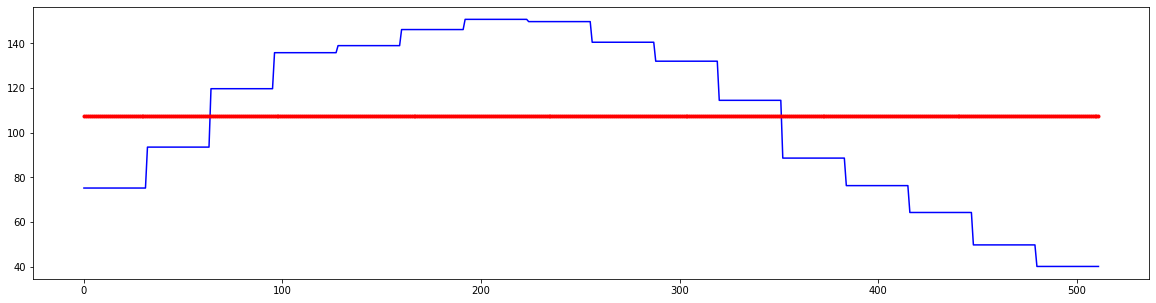

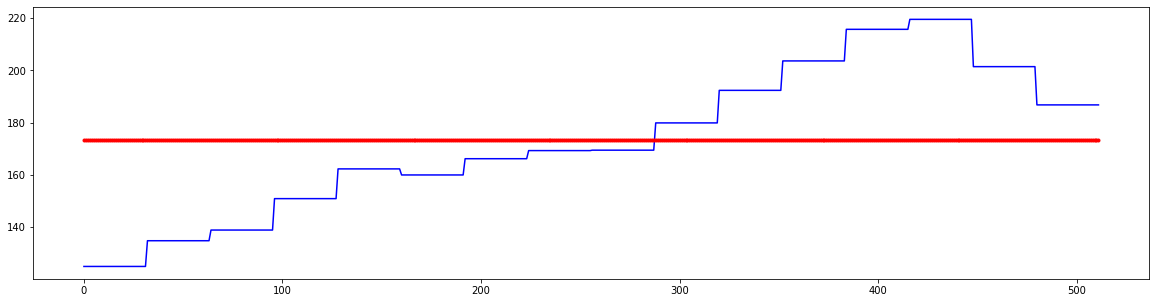

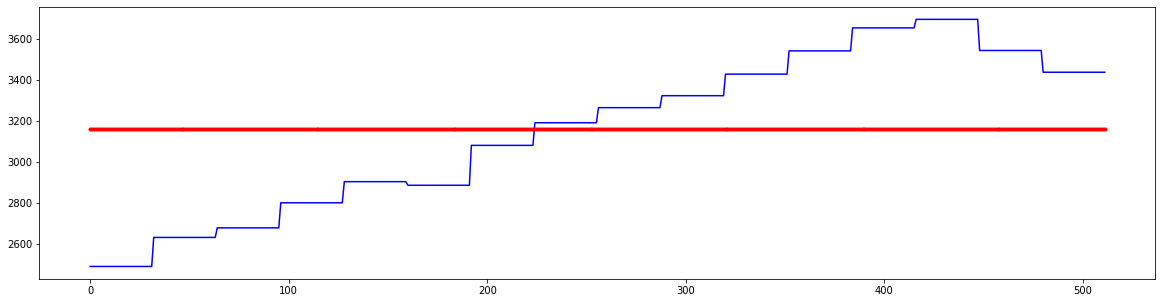

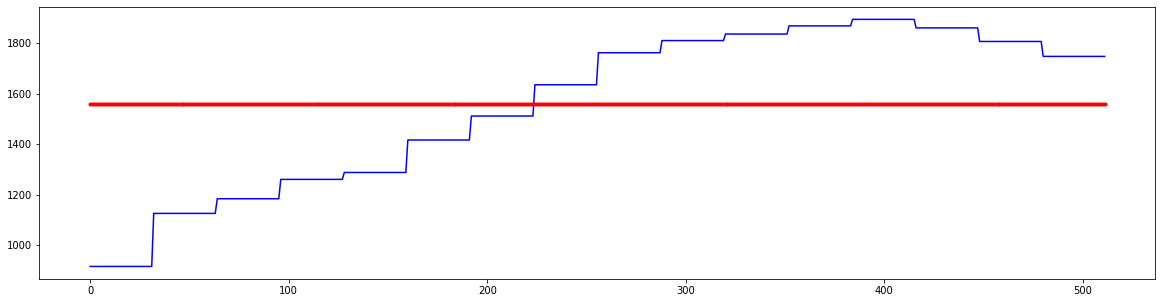

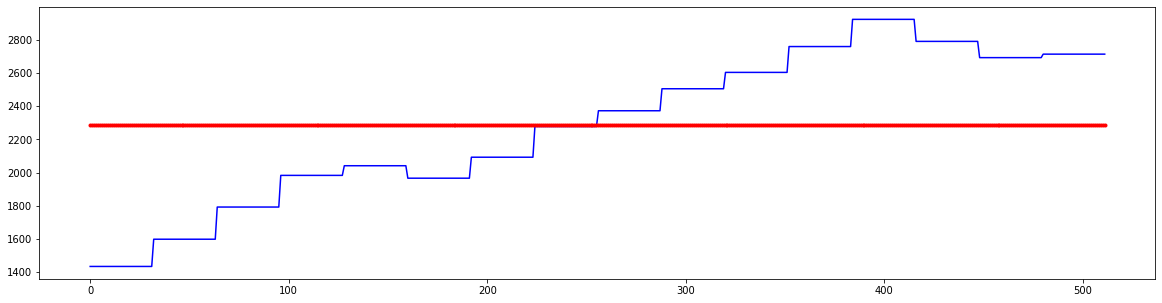

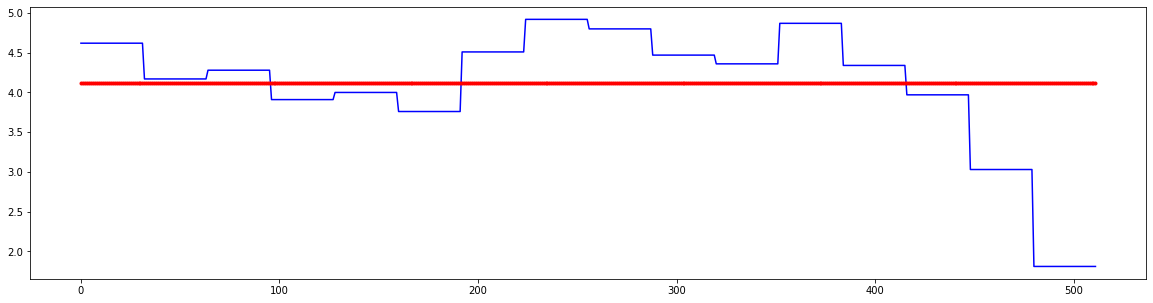

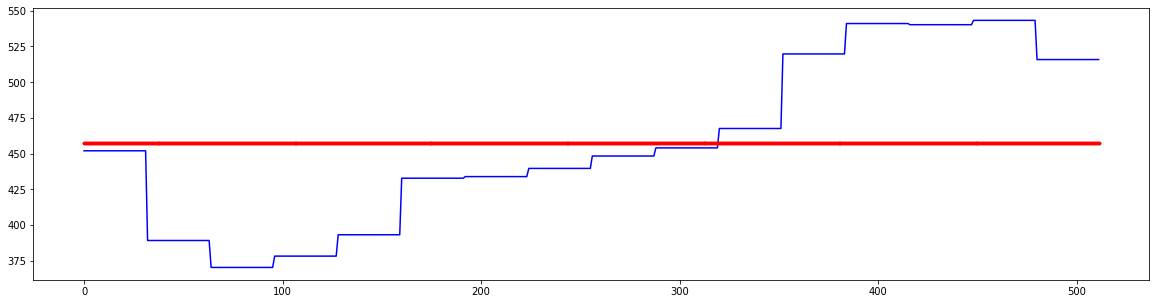

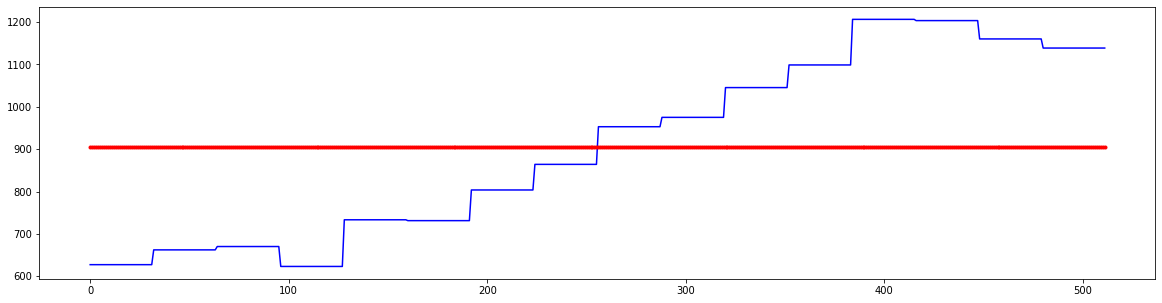

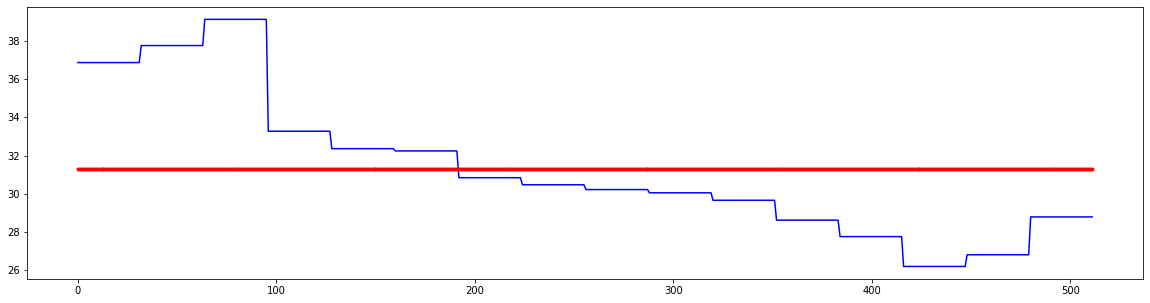

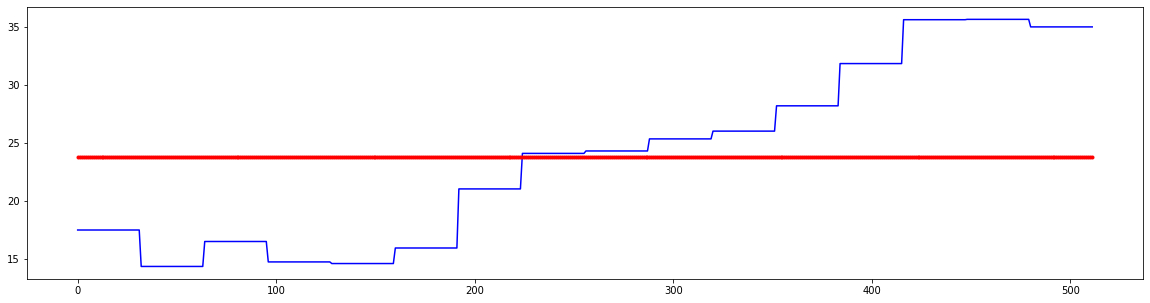

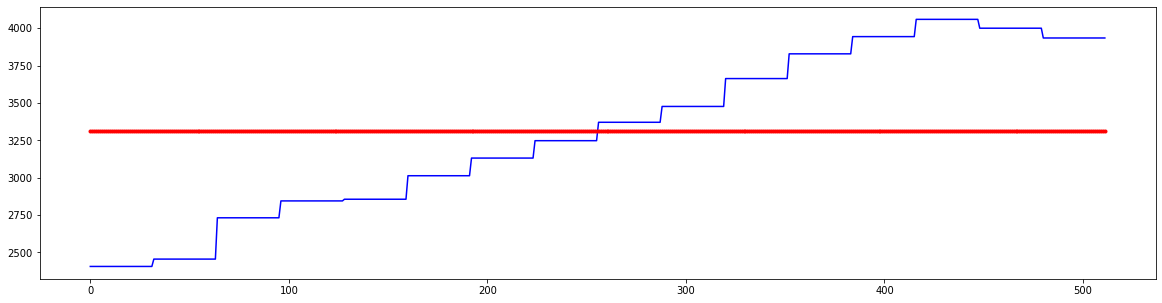

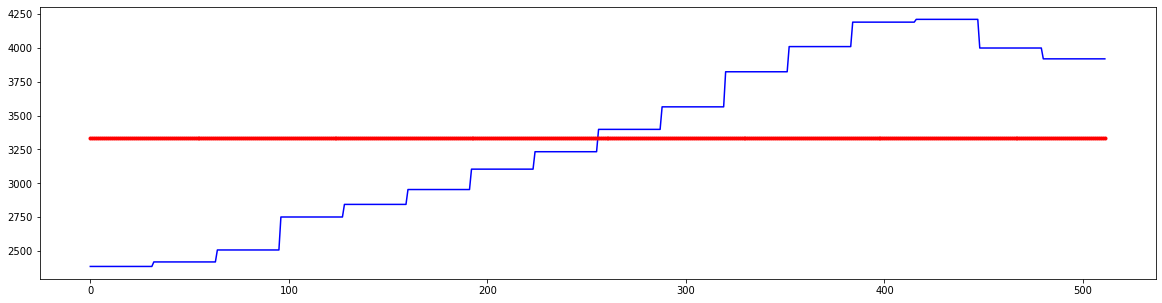

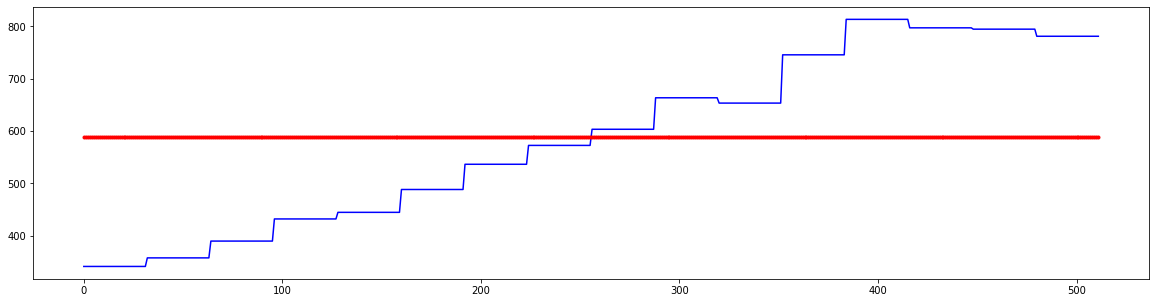

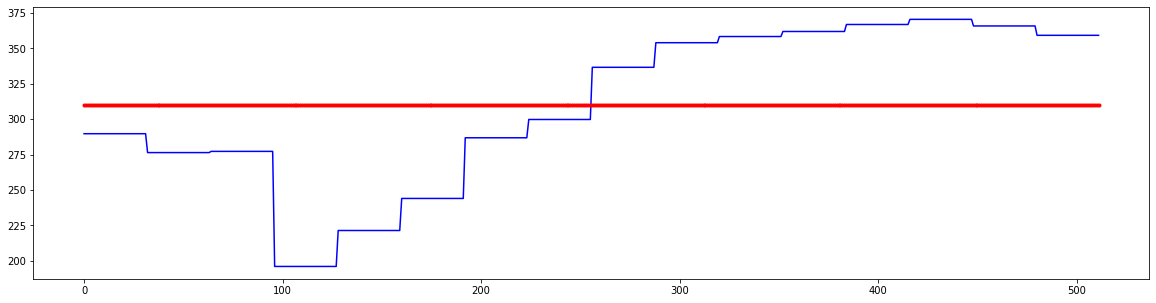

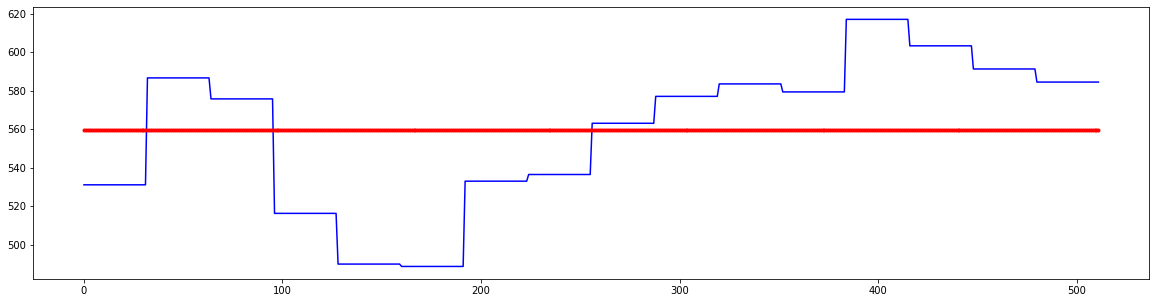

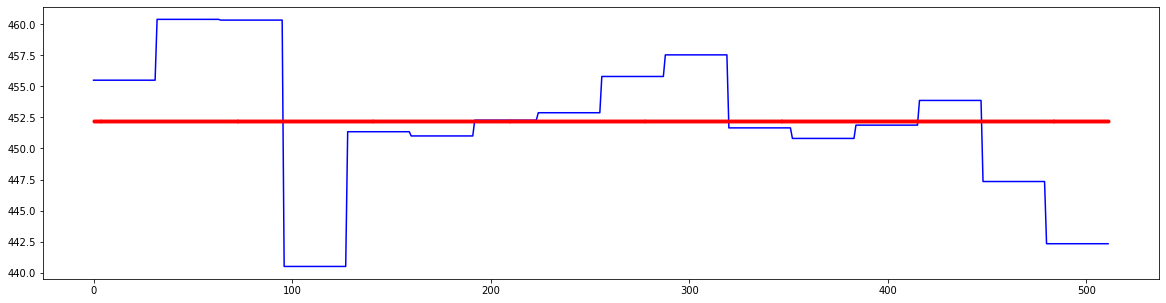

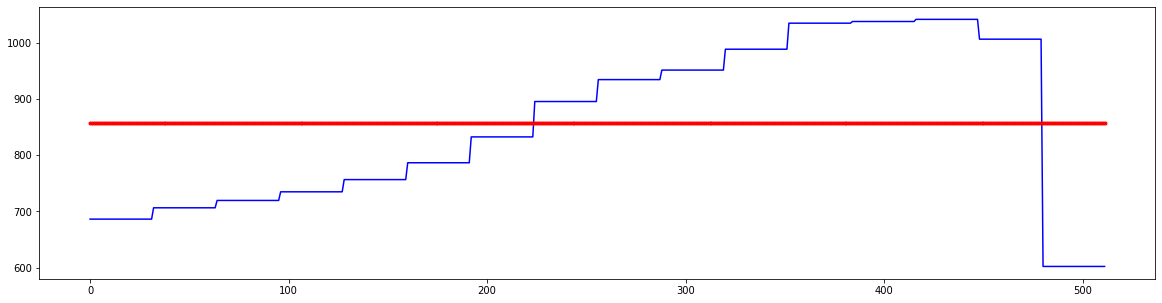

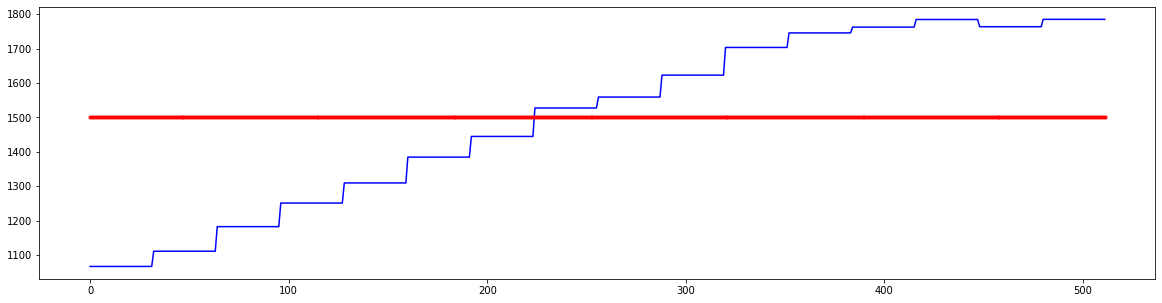

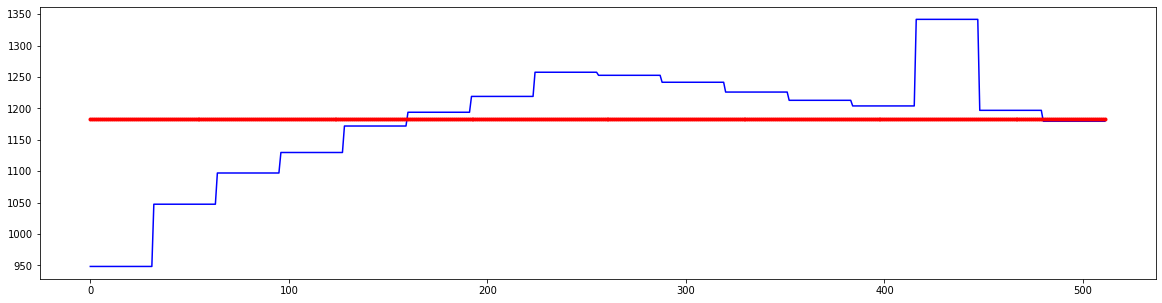

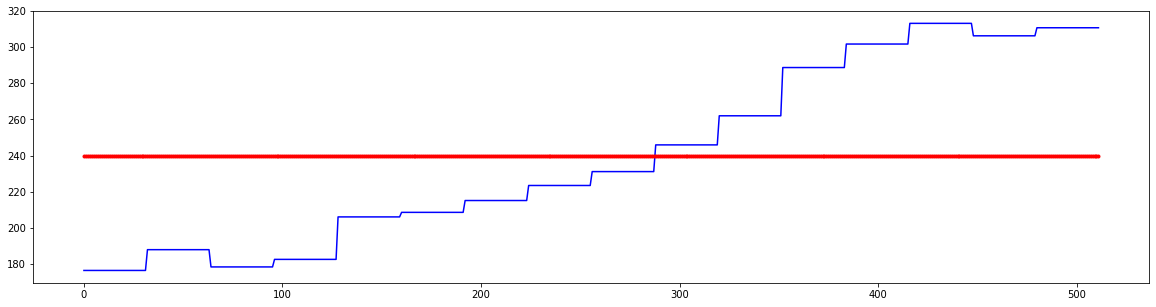

10240


,Unnamed: 0,years,yield,sownareas,mean_areas,yieldvals,county,MODIS,time_idx,band_0_0,...,band_8_502,band_8_503,band_8_504,band_8_505,band_8_506,band_8_507,band_8_508,band_8_509,band_8_510,band_8_511
0,0,2003,0.612950,75.21,107.25,46.10,0,MOD_0,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2003,0.612950,75.21,107.25,46.10,0,MOD_1,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2003,0.612950,75.21,107.25,46.10,0,MOD_2,2,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2003,0.612950,75.21,107.25,46.10,0,MOD_3,3,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2003,0.612950,75.21,107.25,46.10,0,MOD_4,4,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,635,2018,0.754915,310.79,239.87,234.62,29,MOD_27,27,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10236,636,2018,0.754915,310.79,239.87,234.62,29,MOD_28,28,0.000016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10237,637,2018,0.754915,310.79,239.87,234.62,29,MOD_29,29,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10238,638,2018,0.754915,310.79,239.87,234.62,29,MOD_30,30,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from matplotlib import pyplot as plt

data['county'] = data['county'].astype(int)

# dff = data.copy()

# # df = data[ data['county'] ==  4]

print(data['county'].unique())

mean_sownareas = []
# mean_yields = []
for county in list(data['county'].unique()):
    df = data[ data['county'] ==  county]
    X = [X for X in range(0, len(df['sownareas']))]

    mean_sownarea = df['sownareas'].mean()
    # mean_yields = df['yieldvals'].mean()
    # print(type(mean_sownarea))
    # print(type(mean_sownarea.round(2) * np.ones((len(X),1))))
    mean_sownareas.extend(mean_sownarea.round(2) * np.ones((len(X),1)))
    # mean_yields.extend(mean_yields.round(2) * np.ones((len(X),1)))

    # print(mean_sownarea, df['sownareas'])    

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

    ax1.plot(X, np.asarray(df['sownareas']), 'b', label="Actual")
    ax1.plot(X, mean_sownarea * np.ones((len(X),1)), 'r.', label="Mean")
    
    # ax2.plot(X, np.asarray(df['yieldvals']), color='g', label="Actual")
    # ax2.plot(X, mean_yields * np.ones((len(X),1)), color='r.', label="Mean")
    
plt.show()

print(len(mean_sownareas))

data.insert(4, "mean_areas", np.asarray(mean_sownareas).astype(np.float64))  

data

In [6]:
data['years'] = data['years'].astype(str)
data['county'] = data['county'].astype(str)
data['time_idx'] = data['time_idx'].astype(np.int64)
# data.head()
print(type(data['band_0_500'][0]))

<class 'numpy.float64'>


In [7]:
data.describe()

,Unnamed: 0,yield,sownareas,mean_areas,yieldvals,time_idx,band_0_0,band_0_1,band_0_2,band_0_3,...,band_8_502,band_8_503,band_8_504,band_8_505,band_8_506,band_8_507,band_8_508,band_8_509,band_8_510,band_8_511
count,10240.000000,10240.000000,10240.000000,10240.000000,10240.000000,10240.000000,10240.000000,10240.000000,10240.000000,10240.000000,...,1.024000e+04,1.024000e+04,1.024000e+04,1.024000e+04,1.024000e+04,1.024000e+04,1.024000e+04,1.024000e+04,1.024000e+04,1.024000e+04
mean,469.500000,0.518693,1051.865937,1051.865500,563.168281,15.500000,0.000158,0.000013,0.000014,0.000015,...,2.085478e-07,2.020288e-07,2.174697e-07,1.550585e-07,1.190518e-07,1.448605e-07,1.642807e-07,2.693864e-07,1.782708e-07,5.179487e-08
std,275.028429,0.107308,1125.139484,1096.219543,659.061389,9.233544,0.000834,0.000086,0.000073,0.000077,...,8.233659e-06,6.360692e-06,9.206207e-06,5.305438e-06,3.493521e-06,5.882601e-06,5.650697e-06,1.294876e-05,1.031637e-05,1.867692e-06
min,0.000000,0.276526,1.810000,4.110000,1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,232.000000,0.439633,195.160000,223.272500,117.502500,7.750000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,465.000000,0.518948,576.355000,574.105000,262.060000,15.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,703.250000,0.574751,1535.467500,1514.735000,710.202500,23.250000,0.000041,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,959.000000,0.855448,4210.460000,3332.410000,2662.150000,31.000000,0.034574,0.005399,0.002629,0.002457,...,7.321716e-04,4.791045e-04,7.695267e-04,3.547672e-04,2.012576e-04,5.226595e-04,2.943380e-04,1.221001e-03,1.013905e-03,1.319261e-04


In [8]:
from pytorch_lightning.utilities.model_summary import summarize
from pytorch_forecasting.metrics import MAE, RMSE

# predicted_year = "2010"

# create the dataset from the pandas dataframe
train_data = data[ data["years"] != "2018" ]
valid_data = data[ data["years"] == "2018" ]

bins_name = list()   #list(["yield"])
for bin in range(0, 512):
    bins_name.append(f'bin{bin}')

# print(bins_name)

bins_name = list()
for band in tqdm(range(0, 9)):
    for bins in range(0, 512):
        bins_name.append( f'band_{band}_{bins}' )

encoder_length = 18
group=["years", "county"]
unknown_categoricals=["years", "county"]
static_categoricals=["years", "county"]
known_reals=["mean_areas"]     #["sownareas"]
known_categoricals=["years", "county"]

train_dataset_with_covariates = TimeSeriesDataSet(
    train_data,
    group_ids=group,
    target="yield",
    time_idx="time_idx",
    min_encoder_length=encoder_length,
    max_encoder_length=encoder_length,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_unknown_reals=bins_name,  #["yield"],
    # time_varying_unknown_categoricals=unknown_categoricals,
    time_varying_known_reals=known_reals,
    # time_varying_known_categoricals=known_categoricals,
    # static_categoricals=static_categoricals,
)

valid_dataset_with_covariates = TimeSeriesDataSet(
    valid_data,
    group_ids=group,
    target="yield",
    time_idx="time_idx",
    min_encoder_length=encoder_length,
    max_encoder_length=encoder_length,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_unknown_reals=bins_name,   #["yield"],
    # time_varying_unknown_categoricals=unknown_categoricals,
    time_varying_known_reals=known_reals,
    # time_varying_known_categoricals=known_categoricals,
    # static_categoricals=static_categoricals,
)

model = TemporalFusionTransformer.from_dataset(
    train_dataset_with_covariates,
    # learning_rate=0.03,
    # hidden_size=16,
    # attention_head_size=4,
    # dropout=0.1,
    # hidden_continuous_size=8,
    # output_size=1,  # 7 quantiles by default
    loss=RMSE(),
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    # reduce_on_plateau_patience=4,
)

# summarize(model,max_depth=-1)  # print model summary
# model.hparams

# fn


100%|██████████| 9/9 [00:00<00:00, 3854.67it/s]


In [9]:
from pytorch_forecasting.metrics import MAE
from pytorch_forecasting import TemporalFusionTransformer
    
# convert datasets to dataloaders for training
batch_size = 42
train_dataloader = train_dataset_with_covariates.to_dataloader(train=True,  batch_size=batch_size, num_workers=2)
valid_dataloader = valid_dataset_with_covariates.to_dataloader(train=False, batch_size=batch_size, num_workers=2)


In [10]:
# convert the dataset to a dataloader
# dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(valid_dataloader))
# print("x =", x)
# print("\ny =", y)
# print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

	encoder_cat = torch.Size([42, 18, 0])
	encoder_cont = torch.Size([42, 18, 4609])
	encoder_target = torch.Size([42, 18])
	encoder_lengths = torch.Size([42])
	decoder_cat = torch.Size([42, 1, 0])
	decoder_cont = torch.Size([42, 1, 4609])
	decoder_target = torch.Size([42, 1])
	decoder_lengths = torch.Size([42])
	decoder_time_idx = torch.Size([42, 1])
	groups = torch.Size([42, 2])
	target_scale = torch.Size([42, 2])


In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

exp_name = "mean_areas"

logger_name = f"TFT_3: exp:{exp_name}, batch_size={batch_size}, encoder_length={encoder_length}, group={group}, known_reals={known_reals}, loss=RMSE"

logger = TensorBoardLogger('/tf_logs', name=logger_name)

# trainer = Trainer(gpus=1, max_epochs=100, limit_train_batches=2606, logger=logger)
trainer = Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=60, log_every_n_steps=1)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
# trainer.validate(model=model, dataloaders=valid_dataloaders)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tf_logs/TFT_3: exp:mean_areas, batch_size=42, encoder_length=18, group=['years', 'county'], known_reals=['mean_areas'], loss=RMSE
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 73.7 K
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwo

Epoch 0:  93%|█████████▎| 100/107 [29:50<02:05, 17.90s/it, loss=0.107, v_num=0, train_loss_step=0.103] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  93%|█████████▎| 100/107 [30:50<02:09, 18.50s/it, loss=0.099, v_num=0, train_loss_step=0.116, val_loss=0.104, train_loss_epoch=0.113]  
Validation: 0it [00:00, ?it/s]
Epoch 2:  93%|█████████▎| 100/107 [28:54<02:01, 17.35s/it, loss=0.0831, v_num=0, train_loss_step=0.0921, val_loss=0.0913, train_loss_epoch=0.104]
Validation: 0it [00:00, ?it/s]
Epoch 3:  93%|█████████▎| 100/107 [29:22<02:03, 17.63s/it, loss=0.0733, v_num=0, train_loss_step=0.083, val_loss=0.0717, train_loss_epoch=0.091] 
Validation: 0it [00:00, ?it/s]
Epoch 4:  93%|█████████▎| 100/107 [30:15<02:07, 18.15s/it, loss=0.0613, v_num=0, train_loss_step=0.0665, val_loss=0.0567, train_loss_epoch=0.0754]
Validation: 0it [00:00, ?it/s]
Epoch 5:  93%|█████████▎| 100/107 [30:24<02:07, 18.24s/it, loss=0.0529, v_num=0, train_loss_step=0.0579, val_loss=0.056, train_loss_epoch=0.0652]
Validation:

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# trainer.save_checkpoint(f"tft3_best_model_{exp_name}.ckpt")
# best_tft = TemporalFusionTransformer.load_from_checkpoint(f"tft3_best_model_{exp_name}.ckpt")

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(valid_dataloader)])
predictions = best_tft.predict(valid_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
print(type(actuals), actuals.shape, type(predictions), predictions.shape)
# print(actuals, predictions)

In [ ]:
from matplotlib import pyplot as plt

X = [X for X in range(0, actuals.shape[0])]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

ax1.plot(X, actuals, color='b', label="Actual")
ax1.plot(X, predictions, color='r', label="Predicted")
ax1.set_title(logger_name)

files = os.path.join(home_dir, f'TFT{batch_size}_3_{exp_name}.png')
plt.savefig(files, bbox_inches='tight')
plt.show()


In [ ]:
X = [X for X in range(0, actuals.shape[0])]
X = [X for X in range(1, 21)]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

outs = int( actuals.shape[0] / 20 )

act = []
pred = []
for ii in range(0,outs*20,outs):
    act.append(actuals[ii:ii+outs].mean())
    pred.append(predictions[ii:ii+outs].mean())

ax1.plot(X, np.asarray(act), 'bo', label="Actual")
ax1.plot(X, np.asarray(pred), 'ro', label="Predicted")
leg = plt.legend(loc='upper center')
plt.xticks(X)
ax1.set_ylim([0, 1])
plt.xlabel("counties")
plt.ylabel("Yield")
ax1.set_title("Corn yield predictions for 2018 with Temporal Fusion Transformer")

files = os.path.join(home_dir, f'TFT{batch_size}_3_corn_yield_{exp_name}.png')
plt.savefig(files, bbox_inches='tight')
plt.show()

In [ ]:
X = [X for X in range(0, actuals.shape[0])]
X = [X for X in range(1, 21)]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

act = []
pred = []
for ii in range(0,outs*20,outs):
    act.append(actuals[ii:ii+outs].mean())
    pred.append(predictions[ii:ii+outs].mean())

ax1.plot(X, (1-np.abs(np.asarray(act)-np.asarray(pred))) * 100, 'bo', label="Actual")
# ax1.plot(X, np.asarray(pred), 'r.', label="Predicted")
ax1.set_ylim([80, 105])
plt.xticks(X)
plt.xlabel("counties")
plt.ylabel("Yild Accuracy")
ax1.set_title("ACCURACY for Temporal Fusion Transformer for 2018 year for corn yield predict") # + logger_name)

files = os.path.join(home_dir, f'TFT{batch_size}_3_corn_accuracy_{exp_name}.png')
plt.savefig(files, bbox_inches='tight')
plt.show()

In [ ]:
mape_df = pd.DataFrame()
for county in range(0,320,16):
    ls1 = []
    ls2 = []
    act = np.asarray(ls1.append(actuals[ii:ii+16].numpy()))
    print(actuals[ii:ii+16])
    pred = predictions[ii:ii+16].numpy()
    print(act.shape)
    print(act)
    accu = np.abs((act - pred)/act)
    print(accu.shape)
    print(accu)
    # print(accu.numpy())
    mape_df = pd.concat([mape_df, pd.DataFrame({ 'county':[county], 'accu':accu })])
    
mape_df

In [ ]:
fn

In [ ]:
max_prediction_length = 3
max_encoder_length = 8
training_cutoff = data["time_idx"].max() - max_prediction_length

# print(training_cutoff)
# x = data[lambda x: x.time_idx <= training_cutoff]
# print()

bins_name = list(["yield"])
for bin in range(0, 512):
  bins_name.append(f'bin{bin}')

print(bins_name)

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx = "time_idx",
    target = "yield",
    group_ids = ["county", "bands", "time"],
    min_encoder_length = max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    min_prediction_length = 1,
    max_prediction_length = max_prediction_length,
    # static_categoricals = ["county"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    # time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = bins_name,
    allow_missing_timesteps = True,
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    # add_relative_time_idx = True,
    # add_target_scales = True,
    # add_encoder_length = True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 1  # set this between 32 to 128
train_dataloader = training.to_dataloader(train =  True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)


In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(valid_dataloader)])
baseline_predictions = Baseline().predict(valid_dataloader)
(actuals - baseline_predictions).abs().mean().item()

In [ ]:
# configure network and trainer
# pl.seed_everything(42)
# trainer = pl.Trainer(
#     gpus=0,
#     # clipping gradients is a hyperparameter and important to prevent divergance
#     # of the gradient for recurrent neural networks
#     gradient_clip_val=0.1,
#     auto_lr_find = True,
# )


# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # not meaningful for finding the learning rate but otherwise very important
#     learning_rate=0.03,
#     hidden_size=16,  # most important hyperparameter apart from learning rate
#     # number of attention heads. Set to up to 4 for large datasets
#     attention_head_size=1,
#     dropout=0.1,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=8,  # set to <= hidden_size
#     output_size=1,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     # reduce learning rate if no improvement in validation loss after x epochs
#     reduce_on_plateau_patience=4,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# # res = trainer.tuner.lr_find(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,)

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=300,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=MAPE(),  #QuantileLoss(), #MAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
fn

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)